# Semantic Segmentation On Coco (2017) Dataset 

Обработано на предварительно скачанном датасете официального сайта http://cocodataset.org/#download

In [1]:
%matplotlib inline
import tensorflow as tf
import skimage.io as io
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
from pycocotools.coco import COCO

## Подготовка COCO API

In [ ]:
"""
Windows 10, Microsoft Build Tools 2015
Устанавливать cocoApi лучше в новую среду с заранее установленными пакетами git и tensorflow 
для предотвращения исключений при установки
"""
# !pip install "git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI"

In [2]:
COCO_ROOT = os.path.expanduser('~/downloaded_datasets/fast-ai-coco') # Путь к папке с датасетом

sys.path.insert(0, os.path.join(COCO_ROOT, 'cocoapi/PythonAPI'))

## Пайплайн загрузки датасета

In [3]:
# Настройки модели

BATCH_SIZE = 16 # Обработка больших размеров батча может вызвать переполнение памяти
IMG_INP_SIZE = 32*5 # для используемой модели лучше придерживаться размерности, кратной 32
EPOCHS = 1 # 10

In [4]:
class Dataset():
    
    """
    Универсальный класс предобработки изображений для задач сегментации
    """

    def crop_images(self, img, inp_size, random_crop=False):
        shape = tf.shape(img)
        pad = (
            [0, tf.maximum(inp_size - shape[0], 0)],
            [0, tf.maximum(inp_size - shape[1], 0)],
            [0, 0],
        )
        img = tf.pad(img, pad)

        if random_crop:
            img = tf.image.random_crop(img, (inp_size, inp_size, shape[2]))
        else: # central crop
            shape = tf.shape(img)
            ho = (shape[0] - inp_size) // 2
            wo = (shape[1] - inp_size) // 2
            img = img[ho:ho+inp_size, wo:wo+inp_size, :]

        return img

    def train_dataset(self, batch_size, epochs, inp_size):

        def item_to_images(item):
            random_crop = True
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.shuffle(buffer_size=len(self.img_list))
        dataset = dataset.map(item_to_images)
        dataset = dataset.repeat(epochs)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset

    def val_dataset(self, batch_size, inp_size):

        def item_to_images(item):
            random_crop = False
            img_combined = tf.py_function(self.read_images, [item], tf.uint8)
            img_combined = self.crop_images(img_combined, inp_size, random_crop)

            img = tf.cast(img_combined[...,:3], tf.float32) / np.float32(255.)
            mask_class = tf.cast(img_combined[...,3:4], tf.float32)
            return img, mask_class

        dataset = tf.data.Dataset.from_tensor_slices(self.img_list)
        dataset = dataset.map(item_to_images)
        dataset = dataset.batch(batch_size, drop_remainder=True)

        return dataset
    
    
class COCO_Dataset(Dataset):
    
    """
    Класс для сегментационного датасета COCO
    Класс наследутся от универсльного `Dataset` и реализует кастомную функцию чтения данных.
    """

    def __init__(self, sublist):
        ann_file_fpath = os.path.join(COCO_ROOT, 'annotations', 'instances_'+sublist+'2017.json')
        self.coco = COCO(ann_file_fpath)
        self.cat_ids = self.coco.getCatIds(catNms=['person'])
        self.img_list = self.coco.getImgIds(catIds=self.cat_ids)

    def read_images(self, img_id):
        img_id = int(img_id.numpy())
        img_data = self.coco.loadImgs(img_id)[0]
        img_fname = '/'.join(img_data['coco_url'].split('/')[-2:])

        img = io.imread(os.path.join(COCO_ROOT, img_fname))
        if len(img.shape) == 2:
            img = np.tile(img[..., None], (1, 1, 3))

        ann_ids = self.coco.getAnnIds(imgIds=img_data['id'], catIds=self.cat_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        mask_class = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        for i in range(len(anns)):
            mask_class += self.coco.annToMask(anns[i])
        mask_class = (mask_class > 0).astype(np.uint8)

        img_combined = np.concatenate([img, mask_class[..., None]], axis=2)

        return img_combined

In [5]:
COCO_dataset_train = COCO_Dataset('train')
COCO_dataset_val = COCO_Dataset('val')

loading annotations into memory...
Done (t=16.35s)
creating index...
index created!
loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


In [6]:
train_ds = COCO_dataset_train.train_dataset(batch_size=BATCH_SIZE, epochs=EPOCHS, inp_size=IMG_INP_SIZE)
val_ds = COCO_dataset_val.val_dataset(batch_size=BATCH_SIZE, inp_size=IMG_INP_SIZE)

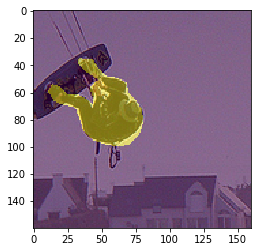

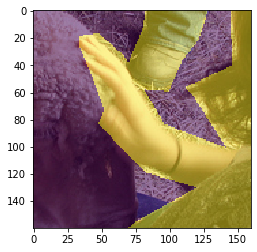

In [54]:
# Визуализация изображений

for idx in range(2):
    i = next(iter(val_ds))
    sample = i[0][idx].numpy()
    seg_map = plt.get_cmap('viridis')(i[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + seg_map*0.5)
    plt.show()

## Подготовка модели

In [7]:
# U-Net
def build_model():
    x = tf.keras.layers.Input((IMG_INP_SIZE, IMG_INP_SIZE, 3))
    
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(x)
    out1 = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out1)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out2 = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out2)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out3 = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out4 = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.MaxPool2D((2, 2))(out4)

    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1024, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out4, out], axis=3)

    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(512, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out3, out], axis=3)

    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(256, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out2, out], axis=3)

    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu')(out)

    out = tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(out)
    out = tf.concat([out1, out], axis=3)

    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu')(out)
    out = tf.keras.layers.Conv2D(1, (3, 3), padding='same', activation='sigmoid')(out)

    return tf.keras.Model(inputs=x, outputs=out)

model = build_model()

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 160, 160, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 80, 80, 64)   0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [9]:
# try:
#     del model
#     K.clear_session()
# except:
#     pass
model = build_model()

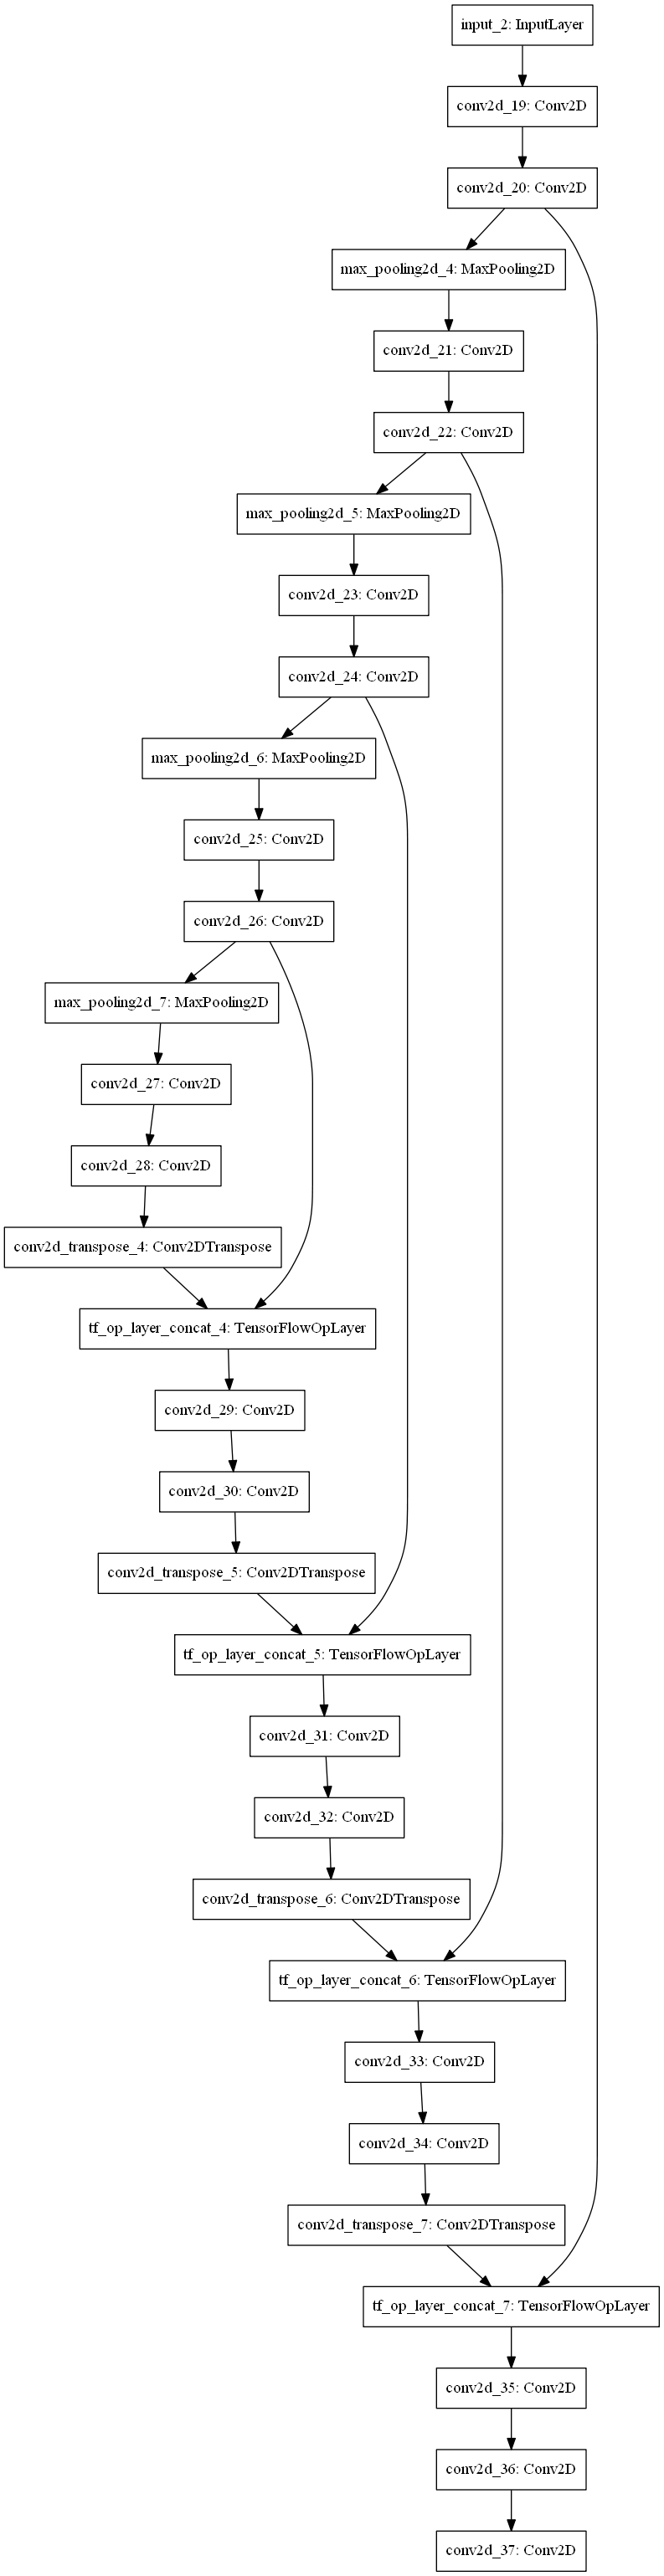

In [10]:
tf.keras.utils.plot_model(model)

In [11]:
loss = tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer="adam", loss=loss)

## Обучение и оценка результата

In [12]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                           min_delta=1e-6,
                                                           patience=50,
                                                           verbose=1,
                                                           mode='auto',
                                                           baseline=None,
                                                           restore_best_weights=True)
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                               patience=5,
                                                               verbose=1,
                                                               factor=0.5,
                                                               min_lr=0.00000001)

In [13]:
train_ds

<BatchDataset shapes: ((16, 160, 160, None), (16, 160, 160, None)), types: (tf.float32, tf.float32)>

In [23]:
%%time

history = model.fit(train_ds, 
                 epochs=EPOCHS,
                 steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE, 
                 validation_data=val_ds, 
                 validation_steps=10,
                   callbacks=[learning_rate_reduction, early_stopping_callback])

Train for 4007 steps, validate for 10 steps
4007/4007 [==============================] - 2321s 579ms/step - loss: 0.5087 - val_loss: 0.5925
Wall time: 38min 40s


Можно также немного изменить цикл валидации, включив дополнительный параметр INTERMEDIATE_STEP

Количество шагов в эпохе поделено на INTERMEDIATE_STEP чтобы валидация и отметки в истории были почаще, по факту 1 
полная эпоха будет раз в INTERMEDIATE_STEP отмеченных эпох, поэтому модель будет тренирована EPOCHS полных эпох, а отметок будет в INTERMEDIATE_STEP раз больше.

Модель с этим параметром валидируется иначе: С INTERMEDIATE_STEP модель проходит 200 шагов за одну эпоху, без - 4007 шагов при одинаковом размере батча. Кол-во эпох при этом умножается на этот параметр. По времени обработки 1 эпоха * 20 INTERMEDIATE_STEP (200 шагов) = 20 эпох обрабатывается примерно так же, как 1 эпоха в 4007 шагов. В целом, это введение процесс может ускорить обучение модели

In [14]:
INTERMEDIATE_STEP = 30

history = model.fit(train_ds, 
                 epochs=EPOCHS * INTERMEDIATE_STEP,
                 steps_per_epoch=len(COCO_dataset_train.img_list)//BATCH_SIZE//INTERMEDIATE_STEP, 
                 validation_data=val_ds, 
                 validation_steps=10,
                   callbacks=[learning_rate_reduction, early_stopping_callback], verbose=0)



Epoch 00013: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00029: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.


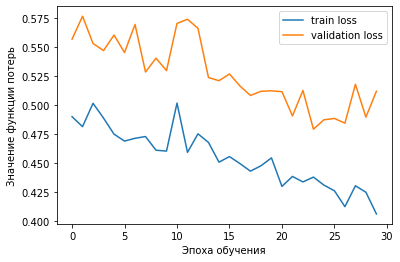

In [15]:
# Loss для модели с INTERMEDIATE_STEP

plt.figure()
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()
plt.show()

In [16]:
test_batch = next(iter(val_ds))
prediction = model.predict(test_batch)

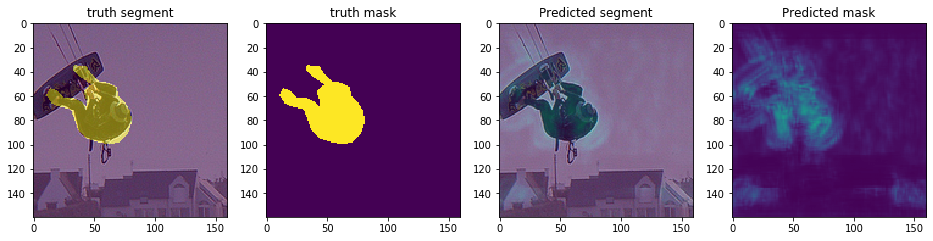

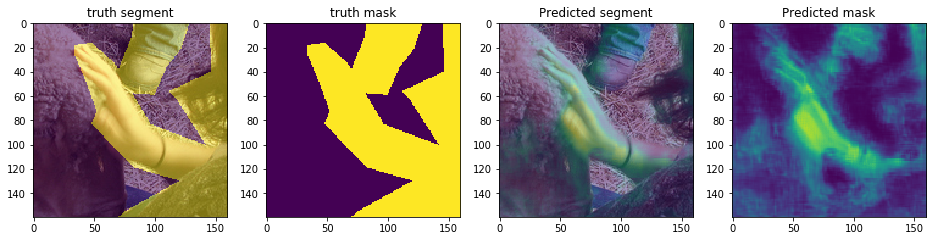

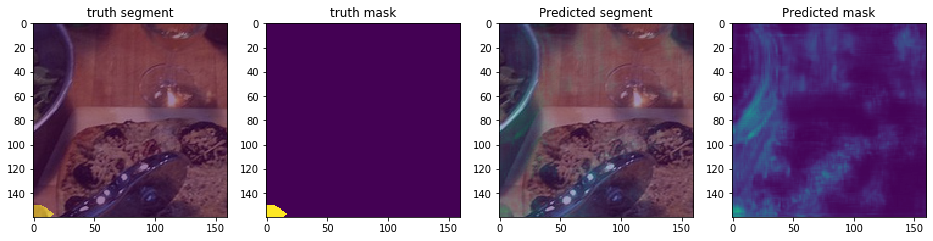

In [66]:
for idx in range(3):
    sample = test_batch[0][idx].numpy()
    
    fig = plt.figure(figsize=(16,6))
    
    plt.subplot(1,4,1)
    plt.title("truth segment")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,2)
    plt.title("truth mask")
    actual_seg_map = plt.get_cmap('viridis')(test_batch[1][idx].numpy().reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    plt.subplot(1,4,3)
    plt.title("Predicted segment")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(sample*0.5 + actual_seg_map*0.5)
    plt.subplot(1,4,4)
    plt.title("Predicted mask")
    actual_seg_map = plt.get_cmap('viridis')(prediction[idx].reshape(IMG_INP_SIZE,IMG_INP_SIZE))[..., :3]
    plt.imshow(actual_seg_map)
    
    plt.show()

## Похоже, модель работает, но что-то обучение затянулось..........
На 10 эпохах обучения можно получить порядка loss 0.2. Похоже, что для приемлемого результата потребуется 100 (около 60 часов, или более 2.5 суток) или 200 эпох.

